---
description: Here we show how to solve the Max-Cut problem introduced by [Sud & Li (2021)] using JijZept and JijModeling.
---

<!-- # 大学キャンパスで感染拡大を抑制するための最適化

## 導入: パンデミック時代に、組合せ最適化ができること -->

# An optimization for preventing a pandemic on a university campus

## Introduction: How to prevent pandemics using a combinatorial optimization?

<!-- 2019年末より世界で始まったCOVID-19感染拡大は、これまでの人々の生活を一変させました。このパンデミックにより、大学生はキャンパスへの入場が一時的に制限されました。[Sud & Li, 2021](https://doi.org/10.48550/arXiv.2112.01220)では、大学キャンパスの学生グループを物理的な感染拡大防止のコホートにマッピングするための、量子アニーリングを用いた最大カット問題の再帰的解法を考案しました。今回はこのアルゴリズム実装に、JijModelingとJijZeptを用いてみましょう。またそのコホートから実際に感染症モデルを解き、感染がどの程度広がるかを見てみましょう。 -->

The pandemic of COVID-19, which began worldwide at the end of 2019, has changed people's lives.
The pandemic resulted in temporary restrictions on admission to the campus for college students.
[Sud & Li (2021)](https://doi.org/10.48550/arXiv.2112.01220) introduced a recursive approach to Max-Cut problem using quantum annealing to map groups of students on college campuses into cohorts and showed a result of preventing infection spread.
In this tutorial, we use JijModeling and JijZept for implementing this algorithm.
We also solve an actual infection model from that cohort and see how much the infection spreads.

<!-- ## アルゴリズム -->

## Algorithm for making cohorts

<!-- 学生をいくつかのグループに分割し、キャンパスに登校する日や使用する教室を分けることで、感染の拡大を防止します。そのために、学生の繋がりをグラフとして考えましょう。そのグラフの最大カット問題を解き、グラフを2つに分けます。最大カット問題を解くことを繰り返し、欲しい数のコホートに到達したら、その時点で繰り返しを終了します。 -->

By dividing students into several groups, separating the days they come to campus and the classrooms they use, to prevent the spread of infection.
To do this, we consider the connections between students as a graph.
We solve that graph as Max-Cut problem, and divide it into two parts.
We repeat solving Max-Cut problem until we get the desired number of cohorts, at which point we end the iteration.

<!-- ```python
G = 入力ネットワークグラフ
N = 希望するコホート数 // ここでは2のべき乗とします
currCohorts = [G]
currCohortsの長さがNより小さい間は以下の処理を繰り返し
          newCohorts = []
          for c in currCohorts:
                    c1, c2 = performMaxcut(c) // 最大カット問題で、グラフを2つに分割
                    newCohorts.append(c1)
                    newCohorts.append(c2)
          currCohorts = newCohorts
``` -->

```python
G = Network Graph
N = Target number of cohorts (power of 2)
currCohorts = [G]
while currCohorts.length < N do
    newCohorts = []
    for c in currCohorts do
        c1, c2 = performMaxcut(c)
        newCohorts.append(c1)
        newCohorts.append(c2)
    end
    currCohorts = newCohorts
end
```

<!-- 後述するperformMaxcut関数は、最大カット問題を解き、グラフを2つに分割する関数です。論文ではD-Waveの量子アニーラを用いていますが、今回はこの部分にJijModeling, そしてJijZeptを用いましょう。 -->

`performMaxcut` function, which we describe and implement later, is a function that solves the maximum cut problem and splits the graph into two parts. 
[Sud & Li (2021)](https://doi.org/10.48550/arXiv.2112.01220) use a D-Wave quantum annealer. 
Here, we implement `performMaxcut` using JijModeling, and JijZept.

<!--  ## 最大カット問題の数理モデル -->

## A mathematical model for Max-Cut optimization

<!-- グラフ$c = (V, E)$を2つに分割する際に、最大カット問題を解いています。ここではその定式化について考えてみましょう。$c$に属する頂点をプラス・マイナスの2つの集合に分けます。このとき、切断するエッジの重みの総和が最大となるような分け方を求める問題です。 -->

To partition a graph $G = (V, E)$ into two subgraphs, we solve Max-Cut problem.
In the following, we consider its formulation.
We divide the vertices belonging to $G$ into two sets, positive and negative.
The problem is to find the division such that the sum of the weights of the cutted edges is maximized.

<!-- ### カットする辺の重みが最大となるようにする -->

### Ensure that the weight of the cutted edge is maximized

<!-- 頂点$i$がプラス集合に属するとき$s_i = 1$、マイナス集合に属するとき$s_i = -1$となるようなスピン変数を与えます。カットする辺の重みが最大となるように考えます。頂点$i$と頂点$j$を結ぶ辺の持つ重みを$w_{ij}$のように書きます。プラス集合に属する頂点とマイナス集合に属する頂点の間のみについて考えるため、その総和は -->

We use spin variables such that $s_i = 1$ when vertex $i$ belong to the positive set and $s_i = -1$ vice versa.
Next, we consider the sum of the cutted edge to have maximum weight. 
We represent the weight that the edge connecting vertex $i$ and vertex $j$ as $w_{ij}$.
Since we consider only between vertices belonging to the positive vertices set and the negative set, the sum of them is written as follows. 

$$
\mathrm{obj} = - \sum_{(i, j) \in E} \frac{w_{ij}}{2} (1-s_i s_j) \tag{1}
$$

<!-- のように書かれます。$s_i = s_j $のとき、$1-s_i s_j = 0$となるため、$s_i \neq s_j$の辺の重みだけが加算されていくことを表現したものです。今回の問題では$w_{ij} = 1$のようにします。すなわち、純粋に学生を2つのグループに分けることを考えます。 -->

When $s_i = s_j$, $1-s_i s_j = 0$, which expresses that only the weights on the edges of $s_i \neq s_j$ are added.
We consider purely dividing the students into two groups.
Therefore we set $w_{ij} = 1$ in this problem.

<!-- ### バイナリ変数との対応 -->

### Conversion to 0/1 variables

<!-- JijModelingはバイナリ変数にのみ対応しているため、スピン変数との対応を考える必要があります。頂点$i$がプラス集合に属するとき$x_i = 1$、マイナス集合に属するとき$x_i = -1$となるようなバイナリ変数を考えましょう。すると、$s_i $と$x_i$の対応は -->

Since JijModeling only supports 0/1 variables, we have to consider the correspondence with spin variables.
Let us consider 0/1 variables such that $x_i = 1$ when the vertex $i$ belongs to the positive set and $x_i = -1$ vice versa.
Then the correspondence between $s_i$ and $x_i$ is

$$
x_i = \frac{1+s_i}{2} \ \Longrightarrow \
s_i = 2 x_i - 1 \tag{2}
$$

<!-- のようになります。 -->

<!-- ## 実装しましょう -->

## Let's coding!

<!-- ここからは、実際にJijModelingとJijZeptを用いて、この問題を解くスクリプトを実装しましょう。 -->

Here, we implement a script that solves this problem using JijModeling and JijZept.

<!-- ### 変数の定義 -->

### Defining variables

<!-- 以下のようにして、最適化に用いる変数を定義します。 -->

We define the variables for Max-Cut problem as follows.

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
w = jm.Placeholder('w', ndim=2)
x = jm.BinaryVar('x', shape=(V, )) 
e = jm.Element('e', belong_to=E)
i = jm.Element('i', belong_to=V)
j = jm.Element('j', belong_to=V)

<!-- `V`はグラフ頂点数、`E`は辺集合、`w`はグラフの重み、そして`x`はバイナリ変数を表します。`e`, `i`, `j`は添字を表す変数です。   -->

`V`, `E`, `w` and `x` denote the number of graph vertices, the edge set, the graph weights, and 0/1 variables, respectively.
`e`, `i` and `j` are varibles for indices.

<!-- ### 最大カット問題の実装 -->

### Implementation for Max-Cut problem

<!-- 次に、最大カット問題の目的関数(1)式を実装しましょう。 -->

Next, we implement the objective function (1) for the Max-Cut problem.

In [2]:
# make problem
problem = jm.Problem('Max cut')
# set spin variables
si = 2 * x[e[0]] - 1
sj = 2 * x[e[1]] - 1
# set objective function: maximize the cut-edge weights
obj = - jm.sum(e, 0.5*w[e[0], e[1]]*(1-si*sj))
problem += obj

<!-- 途中、2つのスピン変数を定義し、それを用いて(1)式の実装を行なっています。  
Jupyter Notebookであれば、実装された数理モデルを確認することができます。 -->

First, we define two spin variables, and then we implement equation (1).  
With Jupyter Notebook, we can check the mathematical model implemented.

In [3]:
problem

<!-- ### グラフ生成 -->

### Generating Networks

<!-- 大学キャンパスなど、複数の人間が形成するネットワークを模倣したグラフを作成しましょう。
ここでは[Watts & Strogatz, 1998](https://www.nature.com/articles/30918)で提案されたsmall-worldグラフを採用します。 -->

We create a graph that imitates a network formed by multiple people, such as on a college campus.
Here we adopt the small-world graph proposed in [Watts & Strogatz(1998)](https://www.nature.com/articles/30918).

In [4]:
import networkx as nx
import numpy as np

# set a small-world graph
inst_V = 1000
k = 20
p = 0.1
inst_G = nx.watts_strogatz_graph(inst_V, k, p)
# set weights on the edges
for edge in inst_G.edges:
    inst_G[edge[0]][edge[1]]['weight'] = 1.0

<!-- ### JijZeptによる求解 -->

### Solving with JijZept

<!-- JijZeptのシミュレーテッド・アニーリング機能を用いて、最大カット問題を解きます。 -->

We solve Max-Cut problem using simulated annealing approach with JijZept.

In [5]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config='../config.toml')
# set multipliers
multipliers = {}

<!-- 今回は制約が存在しないため、未定乗数には空の辞書を設定します。
次に、最大カット問題を反復するための関数群を作成します。 -->

In this problem, we have no constraints. 
Therefore, we set an empty dictionary for the undefined multiplier.
Next, we write functions for iteratively performing  Max-Cut optimization.

In [6]:
# a function to prepare a graph instance for MaxCut
def make_instance(input_c):
    # get the number of nodes
    inst_V = len(input_c.nodes)
    # relavel name of nodes
    mapping_dict = {a: b for a, b in zip(input_c.nodes, range(inst_V))}
    c = nx.relabel_nodes(input_c, mapping_dict)
    # get edges and weights
    inst_E = [[edge[0], edge[1]] for edge in c.edges]
    inst_w = np.zeros([inst_V, inst_V])
    for k, v in nx.get_edge_attributes(c, 'weight').items():
        inst_w[k[0], k[1]] = v
    return {'V': inst_V, 'E': inst_E, 'w': inst_w}

# a function to make two graph from JijZept results
def make_graph(results, c):
    # get feasible solutions
    feasibles = results.feasible()
    if feasibles.evaluation.objective == []:
        print('No feasibles solution ')
    else:
        # get values of objective function
        objs = feasibles.evaluation.objective
        # get the index of minimum objective value
        min_obj_index = np.argmin(objs)
        # get solution
        x = feasibles.record.solution['x'][min_obj_index]
        # extract a subgraph (x=1) from original graph
        c1 = c.copy()
        c1 = c1.subgraph(x[0][0])
        # remove a subgraph from original graph
        c2 = c.copy()
        c2.remove_nodes_from(x[0][0])
        return c1, c2

# execute MaxCut
def performMaxcut(c):
    instance_data = make_instance(c)
    # compute SA with JijZept
    results = sampler.sample_model(problem, instance_data, multipliers, search=True, num_reads=100)
    return make_graph(results, c)

<!-- 上述の関数を用いて、繰り返し最大カット問題を解きましょう。 -->

We solve Max-Cut problem iteratively using the functions described above.

In [7]:
# set the number of cohorts
N = 4
currCohorts = [inst_G, ]
# iteration
while len(currCohorts) < N:
    newCohorts = []
    for c in currCohorts:
        c1, c2 = performMaxcut(c)
        newCohorts.extend([c1, c2])
    currCohorts = newCohorts

/tmp/ipykernel_7008/3764039637.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:


<!-- この計算により、`N`個に分割されたグラフを得ることができます。 -->

This calculation yields `N` graphs.

<!-- ### 感染症モデルへの入力 -->

### Input to SIR epidemic model

<!-- 感染症のよく知られたモデルの一つに、[Kermack & McKendrick (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118)で導入されたSIRモデルがあります。
このモデルは、以下の3つの微分方程式からなるモデルです。 -->

The SIR model, introduced by [Kermack & McKendrick (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118), is one of the well-known models of infectious diseases.
It consists of the following three differential equations:

$$
\frac{dS}{dt} = -\beta S I \tag{3}
$$

$$
\frac{dI}{dt} = \beta S I - \gamma I \tag{4}
$$

$$
\frac{dR}{dt} = \gamma I \tag{5}
$$

<!-- ここで$S$はsusceptible(未感染者: これから感染する可能性を持つ)、$I$はinfectious(感染者: 他人に移す可能性を持つ)、$R$はrecovered(既感染者: 感染から回復し免疫を持つ)を表します。またパラメータである$\beta, \gamma$はそれぞれ感染症の感染率と回復率を表す定数です。COVID-19においては平均の回復期間が$Tr$ = 10daysと判明していることから、大雑把に$\gamma = 1/ Tr$と与えます。また感染者が感染している間に感染を移す平均人数を$\alpha$のように書くと、これは -->

where $S$ is susceptible (but not yet infected with the disease), $I$ is the number of infectious and $R$ is the number of indiveduals who recoverd from the disease.
The parameters $\beta$ and $\gamma$ are constants that represent the infection and recovery rates, respectively.
In COVID-19, the average recovery period is known to be $Tr$ = 10days, so $\gamma = 1/ Tr$.
Also we write the average number of people who transfer the infection while infected as $\alpha$.
It can be written as:

$$
\alpha = \mathrm{avg\_deg}(G) \times \frac{\beta}{\gamma} \tag{6}
$$

<!-- のように書くことができます。ここで$\mathrm{avg\_deg}(G)$は、学生の繋がりを表すグラフ$G$の平均の次数を表します。COVID-19では$1.5 \leq \alpha \leq 6.7$と判明しているため、(6)式からモデル計算を行うグラフ$G$を与えれば、$\beta$を見積もることが可能です。これらを学生の繋がりを表すグラフに合わせて解くことで、そのキャンパスで感染症がどのように広がるかをモデル化することができます。ここでは、先程のアルゴリズムにより分割された学生のコホートをこのモデルに入力し、感染者数の推移などを見ていきましょう。そのために、グラフのトポロジーも考慮してSIRモデルを解く機能を持つ[NDlibライブラリ](https://link.springer.com/article/10.1007/s41060-017-0086-6)を利用します。 -->

where $\mathrm{avg\_deg}(G)$ denotes the degree of the average of the graph $G$.
$\alpha$ value for COVID-19 has been reported to range from 1.5 to 6.7. 
Using a chosen $\alpha$ value, we can estimate $\beta$ via equation (6).
By solving SIR model equation in connection with the graph of student connections, we can model how infectious diseases spread on the campus.
Now let us input the cohort of students divided by above algorithm into this model and see how the number of infections changes.
Here, we will use [NDlib library](https://link.springer.com/article/10.1007/s41060-017-0086-6), which has the function to solve SIR model that can take into account the graph topology.

In [8]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

# a function for solving SIR model
def solveSIR(g):
    # compute average degree of a graph
    list_degree = [g.degree[n] for n in g.nodes()]
    avg_deg = sum(list_degree) / len(list_degree)
    # set parameters for SIR model
    gamma = 1.0 / 10
    alpha = 3.0
    beta = alpha * gamma / avg_deg
    # set SIR model
    model = ep.SIRModel(g)
    # input parameters
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter('percentage_infected', 0.05)
    model.set_initial_status(cfg)
    # compute SIR model
    iterations = model.iteration_bunch(100)
    trends = model.build_trends(iterations)
    return model, trends

<!-- 比較のために、MaxCutを用いて分割した場合と、ランダムにグラフを分割した場合の計算結果を可視化したものを以下に示します。  -->

For comparison, the following is a visualization of the computation results with MaxCut and a randomly separated graph.

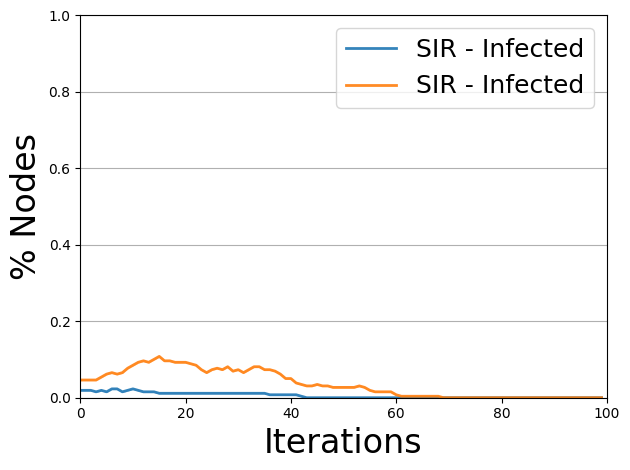

In [11]:
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
import random

# solve SIR model
model1, trends1 = solveSIR(currCohorts[0])

cohort_idx = 0
list_random_partition_nodes = []
for i in inst_G.nodes:
    if random.randint(0, N-1) == cohort_idx:
        list_random_partition_nodes.append(i)
G_temp = inst_G.copy()
random_g = G_temp.subgraph(list_random_partition_nodes)
# solve SIR model
model2, trends2 = solveSIR(random_g)

viz = DiffusionTrendComparison([model1, model2], [trends1, trends2], "Infected")
viz.plot()

<!-- 青線はMaxCut、オレンジ線はランダム分割の場合の感染者数の推移を表しています。
MaxCutを用いた場合の方が、感染者数が少ないことがわかります。
実際に大学キャンパスにおける人同士の接触をグラフ化し、それをこの手法にしたがって分割します。
分割により作成されたグループごとにキャンパスへの登校日を変えれば、感染拡大を防ぐことができるとわかります。 -->

The blue line indicates the number of infected cases with MaxCut and the orange line shows the number of infected cases with random separation.
We can see that the MaxCut scenario is lower than the random one.
We embed the actual human contacts into a graph and partition according to this method. 
Then, we change the day of school attendance on campus for each group created by the partitioning, we prevent the pandemics.

<!-- ## 参考文献 -->

## References

* [Sud & Li, 2021, "A Quantum Annealing Approach to Reduce Covid-19 Spread on College Campuses"](https://arxiv.org/abs/2112.01220)  
* [Watts & Strogatz, 1998, "Collective dynamics of 'small-world' networks"](https://www.nature.com/articles/30918)  
* [Kermack & McKendrick, 1927, "A contribution to the mathematical theory of epidemics"](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118)  
* [Rossetti et al., 2017, "NDLIB: a python library to model and analyze diffusion processes over complex networks"](https://link.springer.com/article/10.1007/s41060-017-0086-6)